In [1]:
# Characterize germline insertions

In [43]:
from collections import (
    defaultdict,
    namedtuple,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import seaborn as sns


PAIRS = {
    'H1': 'H3',
    'H4': 'H6',
    'H7': 'H9',
    'R1': 'R2',
    'R3': 'R4',
    'R5': 'R6',
    'R7': 'R8',
    'R9': 'R10',
    'R11': 'R12',
    'R13': 'R14',
    'R15': 'R16',
    'R17': 'R18',
    'R19': 'R20',
    'R21': 'R22',
    'R23': 'R24',
    'R25': 'R26',
    'R27': 'R28',
    'R29': 'R30',
    'R31': 'R32',
    'R33': 'R34',
    'R35': 'R36',
    'R37': 'R38',
    'R39': 'R40',
    'R41A': 'R42A',
    'R41B': 'R42B',
    'R43': 'R44',
    'R45': 'R46',
    'R47': 'R48',
    'R49': 'R50',
    'R51': 'R52',
    'R53': 'R54',
    'R55': 'R56',
    'R57': 'R58',
    'R59': 'R60',
    'R61': 'R62',
    'R63': 'R64',
}
PAIRS.update({v:k for k,v in PAIRS.items()})


COLUMNS = ['chrom', 'program', 'insertion', 'start', 'end', 'score', 'strand', 'idk', 'attributes']
insertion = namedtuple('Insertion', COLUMNS)

In [44]:
# PUTATIVE_INSERTIONS = '../../pre-processed-data/raw_insertion_calls/all_putative_germline_insertions.gff3'
PUTATIVE_INSERTIONS = '../../pre-processed-data/insertion_calls/coverage/combined_sorted_somatic_insertions.gff'
# COVERAGE_FILE = '../../pre-processed-data/raw_insertion_calls/coverage_over_germline_insertions.tsv'
COVERAGE_FILE = '../../pre-processed-data/insertion_calls/coverage/somatic_coverage.tsv'
# ALL_INSERTIONS = '/Users/mvandenb/Downloads/Galaxy1199-[Concatenate_multiple_datasets_on_data_1198,_data_1197,_and_others].gff3'
ALL_INSERTIONS = PUTATIVE_INSERTIONS
SOMATIC_DATA = ['../../pre-processed-data/insertion_calls/0.5.21.filtered_calls_prosgfp_guts.gff', '../../pre-processed-data/insertion_calls/0.5.21.filtered_calls_prosgfp_heads.gff']
INSERTION_SUMMARY = 'Pros all somatic TSD insertions.tsv'
FINAL_TABLE = 'Pros Final somatic table.tsv'

In [45]:
summary = namedtuple('summary', 'chrom start mate_support split_support nref vaf')


def read_insertions(path):
    all_inserts = defaultdict(list)
    with open(path) as in_fh:
        for line in in_fh:
            fields = line.split()
            chrom = fields[0]
            start = int(fields[3])
            attributes = dict(item.split("=") for item in fields[8].split(";"))
            mate_support = int(attributes['left_mate_count']) + int(attributes['right_mate_count'])
            total_support = int(attributes['total_left_count']) + int(attributes['total_right_count'])
            split_support = total_support - mate_support
            nref = int(attributes['nref'])
            vaf = total_support / (total_support + nref)
            all_inserts[attributes['ID']].append((summary(chrom, start, mate_support, split_support, nref, vaf)))
    return all_inserts

all_inserts = read_insertions(ALL_INSERTIONS)

In [46]:
def find_overlap_support(all_inserts, cluster_id, chrom, start):
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.mate_support, insert.split_support
    return 0, 0

def find_nref(all_inserts, cluster_id, chrom, start):
    # nref = []
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.nref
    return 0

def find_vaf(all_inserts, cluster_id, chrom, start):
    # vaf = []
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.vaf
    return 0

In [47]:
def summarize_overlaps(insertions):
    overlaps = set()
    cluster_ids = set()
    if not insertions:
        raise Exception('nope')
    for index, ins in enumerate(insertions):
        overlaps.add(ins.attributes['ID'].split('_')[0])
        cluster_ids.add(ins.attributes['ID'])
        for overlap in ins.attributes['overlaps'].split(','):
            if overlap:
                cluster_ids.add(overlap)
                overlaps.add(overlap.split('_')[0])
        is_somatic  = (ins.chrom, ins.start, ins.end, ins.insertion) in somatic
    return [index, ins.chrom, ins.start, ins.end, ins.insertion, ins.strand, is_somatic, len(overlaps), cluster_ids]


def get_insertions_by_coordinate(path):
    insertions_by_coordinate = defaultdict(list)
    with open(path) as fh:
        for line in fh:
            fields = line.strip().split('\t')
            fields[8] = dict(item.split("=") for item in fields[8].split(";"))
            ins = insertion(*fields)
            if ins.attributes['valid_TSD'] == 'True':
                insertions_by_coordinate[(ins.chrom, ins.start, ins.end, ins.insertion)].append(ins)
    return insertions_by_coordinate


insertions_by_coordinate = get_insertions_by_coordinate(PUTATIVE_INSERTIONS)


somatic = defaultdict(list)
for dataset in SOMATIC_DATA:
    somatic.update(get_insertions_by_coordinate(dataset))

somatic = {ins: summarize_overlaps(somatic[ins]) for ins in somatic}

In [48]:
len(insertions_by_coordinate)

746

In [49]:
possible_somatic = {k:v for k, v in insertions_by_coordinate.items() if sum(1 for _ in v if _.attributes['overlaps'].count(',') == 0) == len(v)}

In [50]:
len(possible_somatic)

746

In [51]:
possible_private = defaultdict(list)

for insertions in insertions_by_coordinate.values():
    for record in insertions:
        overlaps = [overlap.split('_')[0] for overlap in record.attributes['overlaps'].split(',')]
        if len(overlaps) == 2 and PAIRS[overlaps[0]] == overlaps[1] and record.attributes['valid_TSD'] == 'True':
            possible_private[(record.chrom, record.start, record.end, record.insertion)].append(record)

In [52]:
early_somatic = {k:v for k,v in possible_private.items() if len(v) == 1}

In [53]:
private = {k:v for k,v in possible_private.items() if len(v) == 2}

In [54]:
def merge_connected_clusters(shared_summary):
    new_summary = []
    n_insertions = len(shared_summary)
    skip = -1
    for i, s in enumerate(shared_summary):
        if not skip == i:
            if i < (n_insertions - 1):
                n_s = shared_summary[i + 1]
                if s[-1] & n_s[-1]:
                    s[-1] = s[-1].union(n_s[-1])
                    skip = i + 1
            s[-2] = len(set(overlap.split('_')[0] for overlap in s[-1]))
            new_summary.append(s)
    return new_summary

<AxesSubplot:xlabel='Number of samples with insertion', ylabel='Number of insertion'>

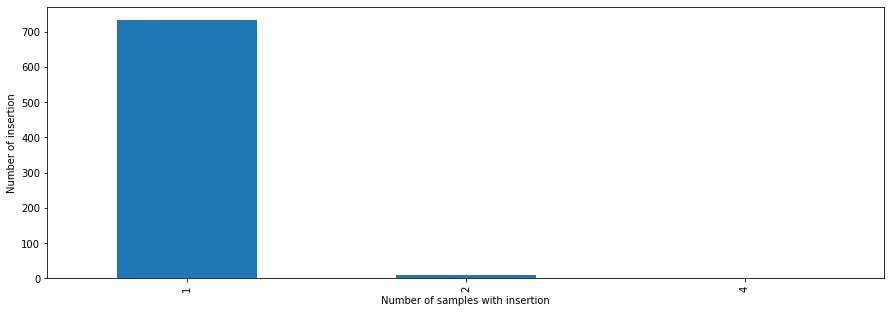

In [55]:
shared_germline = set(insertions_by_coordinate.keys()) - set(possible_somatic.keys()) - set(private.keys())
shared_summary = [summarize_overlaps(insertions_by_coordinate[ins]) for ins in insertions_by_coordinate]

# Make that a recursive call
new_summary = merge_connected_clusters(shared_summary)
new_summary = merge_connected_clusters(list(reversed(new_summary)))
new_summary = merge_connected_clusters(new_summary)
new_summary = list(reversed(merge_connected_clusters(list(reversed(new_summary)))))

shared_df = pd.DataFrame.from_records(shared_summary)
shared_df.columns = ['index', 'chrom', 'start', 'end', 'insertion', 'strand', 'somatic', 'N_samples', 'overlaps',]
shared_df['support'] = shared_df.apply(lambda row: [find_overlap_support(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['nref'] = shared_df.apply(lambda row: [find_nref(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['vaf'] = shared_df.apply(lambda row: [find_vaf(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion")

<AxesSubplot:xlabel='Number of samples with insertion, merge aggressively', ylabel='Number of insertion'>

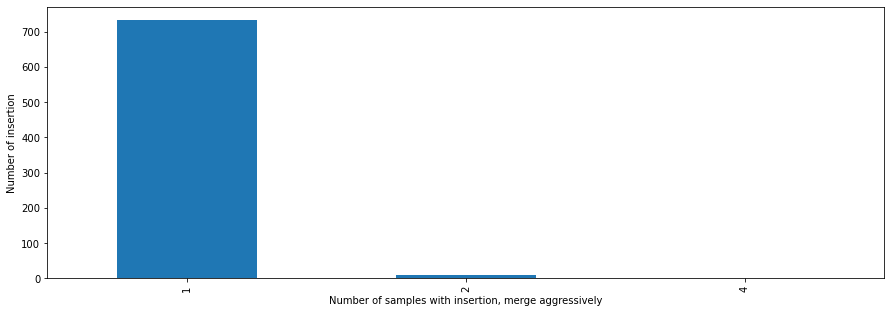

In [56]:
shared_df = pd.DataFrame.from_records(new_summary)
shared_df.columns = ['index', 'chrom', 'start', 'end', 'insertion', 'strand', 'somatic', 'N_samples', 'overlaps']
shared_df['support'] = shared_df.apply(lambda row: [find_overlap_support(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['nref'] = shared_df.apply(lambda row: [find_nref(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['vaf'] = shared_df.apply(lambda row: [find_vaf(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
# shared_df = shared_df[shared_df.somatic == False]
shared_df.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion, merge aggressively")

In [57]:
shared_df.somatic = shared_df.apply(lambda row: (row.chrom, row.start, row.end, row.insertion) in somatic, axis=1)
shared_df['private'] = shared_df.apply(lambda row: (row.chrom, row.start, row.end, row.insertion) in possible_private, axis=1)
shared_df.somatic.value_counts()
no_somatic = shared_df[shared_df.somatic == False]
if not no_somatic.empty:
    no_somatic.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion, merge aggressively, no somatic insertions")

In [58]:
shared_df[(shared_df.somatic == False) & (shared_df.N_samples == 1)]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private


In [59]:
shared_df.strand.value_counts()

+    746
Name: strand, dtype: int64

In [60]:
shared_df[(shared_df.somatic == False) & (shared_df.private == True)].insertion.value_counts()

Series([], Name: insertion, dtype: int64)

In [61]:
shared_df[(shared_df.somatic == False) & (shared_df.insertion == 'rover')].N_samples.value_counts()

Series([], Name: N_samples, dtype: int64)

In [62]:
shared_df[(shared_df.somatic == False) & (shared_df.insertion == 'rover') & (shared_df.N_samples == 68)]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private


In [63]:
shared_df

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
0,0,Y,3631688,3631688,Stalker3,+,True,1,{R30_head_260},"[(10, 2)]",[59],[0.16901408450704225],False
1,0,Y,1445089,1445095,rover,+,True,1,{R43_gut_1},"[(19, 11)]",[12],[0.7142857142857143],False
2,0,X,22848299,22848303,rover,+,True,1,{R39_gut_55},"[(0, 9)]",[21],[0.3],False
3,0,X,22835722,22835727,copia,+,True,1,{R57_gut_87},"[(9, 4)]",[9],[0.5909090909090909],False
4,0,X,22598274,22598286,G-element,+,True,1,{R53_gut_39},"[(0, 3)]",[7],[0.3],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,0,2L,1446792,1446799,rover,+,True,1,{H7_gut_13},"[(12, 15)]",[56],[0.3253012048192771],False
742,0,2L,1140710,1140711,rover,+,True,1,{H7_gut_11},"[(5, 10)]",[53],[0.22058823529411764],False
743,0,2L,1053755,1053758,rover,+,True,1,{R33_gut_0},"[(13, 13)]",[64],[0.28888888888888886],False
744,0,2L,482108,482112,rover,+,True,1,{H4_gut_1},"[(28, 10)]",[24],[0.6129032258064516],False


In [64]:
fully_penetrant = shared_df[shared_df.N_samples == 8]
x = fully_penetrant[['chrom', 'start', 'end', 'insertion']]
y = [insertions_by_coordinate[tuple(r)] for r in x.to_records(index=False)]

if not fully_penetrant.empty:
    # All support
    ratio = []
    x_insertions = []
    plt.figure()
    for insertions in y[50:]:
        for ins in insertions:
            if ins.attributes['genotype'] == 'heterozygous' and int(ins.score) > 15:
                if ins.chrom == 'X':
                    x_insertions.append(ins)
                    continue
                nref = int(ins.attributes['nref'])
                score = int(ins.score)
                ratio.append(score /  (score + nref))
    sns.boxplot(pd.Series(ratio), orient='v').set_title("Count all support")
    (np.percentile(ratio, q=1), np.percentile(ratio, q=99))
    # Mate support
    ratio = []
    plt.figure()
    for insertions in y[50:]:
        for ins in insertions:
            if ins.chrom == 'X':
                continue
            if ins.attributes['genotype'] == 'heterozygous' and int(ins.score) > 15:
                nref = int(ins.attributes['nref'])
                score = int(ins.attributes['left_mate_count']) + int(ins.attributes['right_mate_count'])
                ratio.append(score /  (score + nref))
    sns.boxplot(pd.Series(ratio), orient='v').set_title("Count only mate support")
    (np.percentile(ratio, q=1), np.percentile(ratio, q=99))

In [65]:
shared_df

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
0,0,Y,3631688,3631688,Stalker3,+,True,1,{R30_head_260},"[(10, 2)]",[59],[0.16901408450704225],False
1,0,Y,1445089,1445095,rover,+,True,1,{R43_gut_1},"[(19, 11)]",[12],[0.7142857142857143],False
2,0,X,22848299,22848303,rover,+,True,1,{R39_gut_55},"[(0, 9)]",[21],[0.3],False
3,0,X,22835722,22835727,copia,+,True,1,{R57_gut_87},"[(9, 4)]",[9],[0.5909090909090909],False
4,0,X,22598274,22598286,G-element,+,True,1,{R53_gut_39},"[(0, 3)]",[7],[0.3],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,0,2L,1446792,1446799,rover,+,True,1,{H7_gut_13},"[(12, 15)]",[56],[0.3253012048192771],False
742,0,2L,1140710,1140711,rover,+,True,1,{H7_gut_11},"[(5, 10)]",[53],[0.22058823529411764],False
743,0,2L,1053755,1053758,rover,+,True,1,{R33_gut_0},"[(13, 13)]",[64],[0.28888888888888886],False
744,0,2L,482108,482112,rover,+,True,1,{H4_gut_1},"[(28, 10)]",[24],[0.6129032258064516],False


In [66]:
shared_df.somatic.value_counts()

True    746
Name: somatic, dtype: int64

In [67]:
shared_df.N_samples.value_counts()

1    734
2     11
4      1
Name: N_samples, dtype: int64

In [68]:
shared_df[(shared_df.somatic == True) & (shared_df.N_samples > 1)]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
17,1,X,18663340,18663350,invader1,+,True,2,"{R42B_head_56, R42A_head_56}","[(1, 1), (1, 1)]","[57, 57]","[0.03389830508474576, 0.03389830508474576]",False
109,1,X,5151981,5151982,rover,+,True,2,"{H7_gut_4, R61_gut_4}","[(10, 13), (3, 7)]","[8, 1]","[0.7419354838709677, 0.9090909090909091]",False
309,1,3R,5111084,5111089,rover,+,True,2,"{R49_gut_2, H7_gut_16}","[(20, 10), (0, 11)]","[36, 39]","[0.45454545454545453, 0.22]",False
323,1,3L,25187254,25187254,gypsy4,+,True,2,"{R42B_head_116, R42A_head_116}","[(0, 2), (0, 2)]","[61, 61]","[0.031746031746031744, 0.031746031746031744]",False
326,1,3L,24150795,24150816,Quasimodo,+,True,2,"{R42B_head_67, R42A_head_67}","[(1, 2), (1, 2)]","[80, 80]","[0.03614457831325301, 0.03614457831325301]",False
350,1,3L,19257820,19257825,rover,+,True,2,"{R33_gut_0, R5_gut_1}","[(13, 21), (6, 4)]","[37, 59]","[0.4788732394366197, 0.14492753623188406]",False
401,1,3L,12410280,12410284,rover,+,True,2,"{R33_gut_3, R61_gut_16}","[(14, 18), (33, 28)]","[49, 50]","[0.3950617283950617, 0.5495495495495496]",False
516,1,2R,19670202,19670202,McClintock,+,True,2,"{R42B_head_101, R42A_head_101}","[(2, 1), (2, 1)]","[68, 68]","[0.04225352112676056, 0.04225352112676056]",False
540,3,2R,14919483,14919488,rover,+,True,4,"{R17_gut_3, H7_gut_17, R21_gut_4, H4_gut_9}","[(2, 9), (2, 4), (0, 6), (5, 8)]","[10, 74, 18, 65]","[0.5238095238095238, 0.075, 0.25, 0.1666666666...",False
657,1,2L,17380694,17380699,rover,+,True,2,"{R11_gut_1, R35_gut_0}","[(42, 14), (1, 1)]","[55, 15]","[0.5045045045045045, 0.11764705882352941]",False


In [69]:
pretty_summary = shared_df[['chrom', 'start', 'end', 'insertion', 'somatic', 'private', 'N_samples', 'overlaps']]

In [70]:
pretty_summary.to_csv(INSERTION_SUMMARY, sep='\t', index=None)

In [71]:
pretty_summary

,chrom,start,end,insertion,somatic,private,N_samples,overlaps
0,Y,3631688,3631688,Stalker3,True,False,1,{R30_head_260}
1,Y,1445089,1445095,rover,True,False,1,{R43_gut_1}
2,X,22848299,22848303,rover,True,False,1,{R39_gut_55}
3,X,22835722,22835727,copia,True,False,1,{R57_gut_87}
4,X,22598274,22598286,G-element,True,False,1,{R53_gut_39}
...,...,...,...,...,...,...,...,...
741,2L,1446792,1446799,rover,True,False,1,{H7_gut_13}
742,2L,1140710,1140711,rover,True,False,1,{H7_gut_11}
743,2L,1053755,1053758,rover,True,False,1,{R33_gut_0}
744,2L,482108,482112,rover,True,False,1,{H4_gut_1}


In [72]:
coverage = pd.read_csv(COVERAGE_FILE, sep='\t')

final_table = pd.concat([shared_df, coverage], axis=1)
final_table['median_coverage'] = final_table.iloc[:, 10:].median(axis=1)


def high_and_low_support(list_of_tuples):
    support_one = sum(list_of_tuples[0])
    if len(list_of_tuples) == 1:
        return False
    support_two = sum(list_of_tuples[1])
    if min(support_one, support_two) < 3 and max(support_one, support_two) > 10:
        return True
    return False


final_table['early_developmental'] = (final_table['somatic'] == False) & (final_table['private'] == True) & (final_table['support'].apply(high_and_low_support))

In [73]:
final_table

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,R54_head,R56_head,R58_head,R60_head,R62_head,R64_head,R42A_head,R42B_head,median_coverage,early_developmental
0,0,Y,3631688,3631688,Stalker3,+,True,1,{R30_head_260},"[(10, 2)]",...,70,59,52,45,92,62,59,59,62.0,False
1,0,Y,1445089,1445095,rover,+,True,1,{R43_gut_1},"[(19, 11)]",...,58,40,33,68,38,44,52,52,58.0,False
2,0,X,22848299,22848303,rover,+,True,1,{R39_gut_55},"[(0, 9)]",...,87,69,93,71,88,90,67,67,81.0,False
3,0,X,22835722,22835727,copia,+,True,1,{R57_gut_87},"[(9, 4)]",...,56,42,60,44,49,56,41,41,56.0,False
4,0,X,22598274,22598286,G-element,+,True,1,{R53_gut_39},"[(0, 3)]",...,86,60,89,51,69,77,66,66,69.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,0,2L,1446792,1446799,rover,+,True,1,{H7_gut_13},"[(12, 15)]",...,6,6,5,11,10,4,6,6,8.0,False
742,0,2L,1140710,1140711,rover,+,True,1,{H7_gut_11},"[(5, 10)]",...,10,4,8,9,12,15,7,7,13.0,False
743,0,2L,1053755,1053758,rover,+,True,1,{R33_gut_0},"[(13, 13)]",...,8,3,8,13,11,9,5,5,13.0,False
744,0,2L,482108,482112,rover,+,True,1,{H4_gut_1},"[(28, 10)]",...,24,31,34,22,28,35,32,32,33.0,False


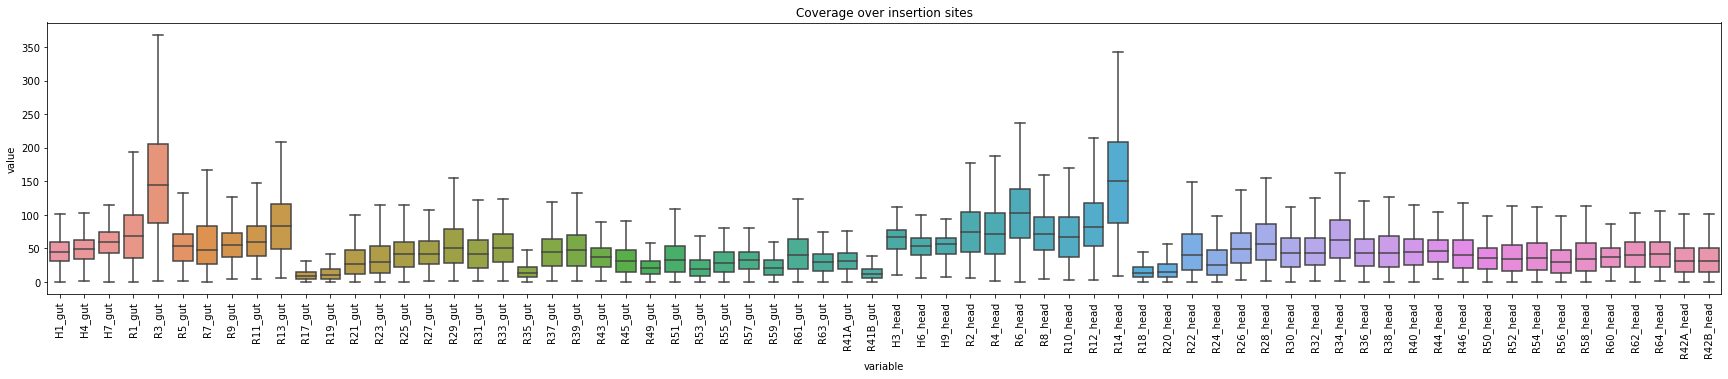

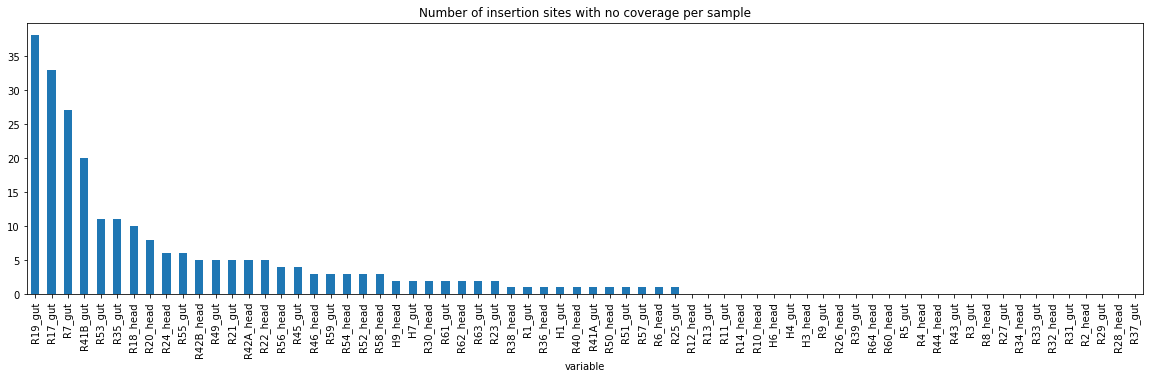

In [74]:
def plot_coverage_data(coverage_data):
    # Coverage over insertion sites
    fig, ax = plt.subplots(figsize=(30, 5))
    sns.boxplot(x='variable', y='value', showfliers = False, data=coverage_data, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title('Coverage over insertion sites')
    
    # Insertion sites without coverage
    fig, ax = plt.subplots(figsize=(30, 5))
    germline_sites_without_coverage = coverage_data['value'].eq(0).astype(int).groupby(coverage_data['variable']).sum().sort_values(ascending=False)
    germline_sites_without_coverage.plot(kind='bar', x='sample', y='count', figsize=(20, 5), title='Number of insertion sites with no coverage per sample', ax=ax)

coverage_data = final_table.iloc[:, 13:-2].melt()
plot_coverage_data(coverage_data)

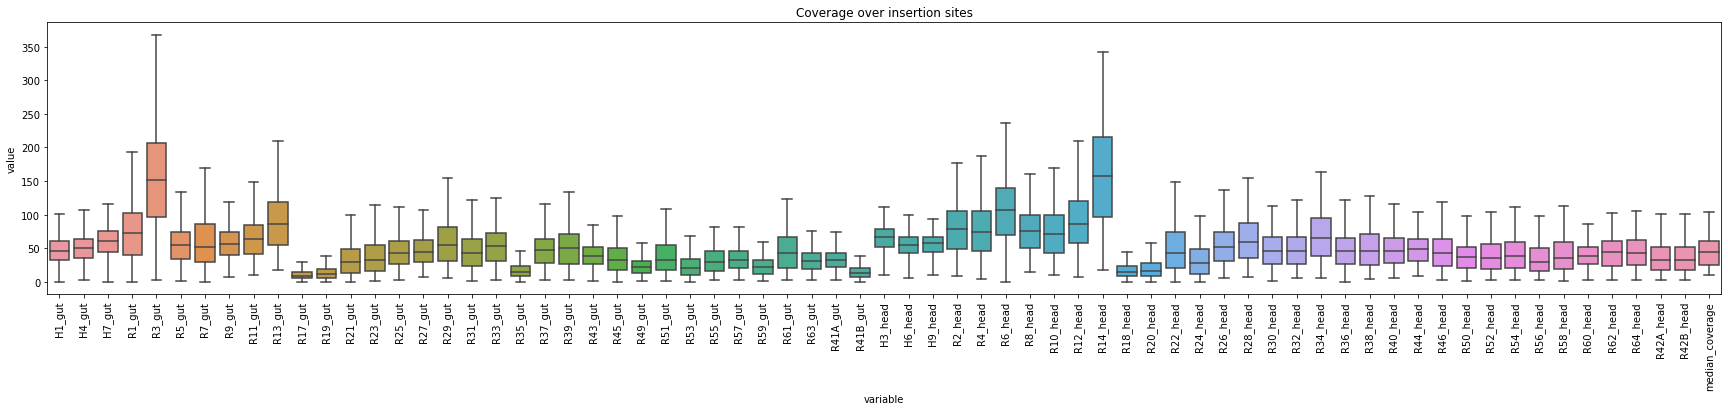

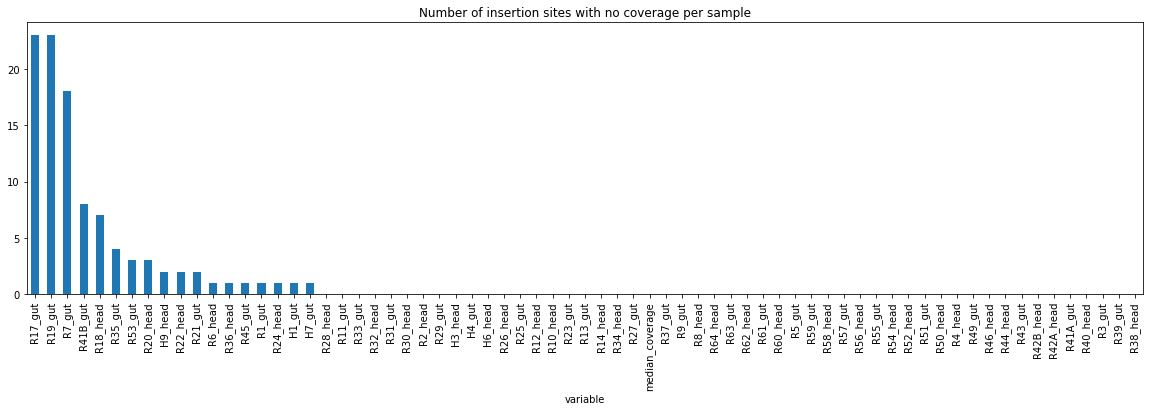

In [75]:
coverage_data = final_table[final_table.median_coverage >= 10].iloc[:, 13:-1].melt()
plot_coverage_data(coverage_data)

In [76]:
final_table

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,R54_head,R56_head,R58_head,R60_head,R62_head,R64_head,R42A_head,R42B_head,median_coverage,early_developmental
0,0,Y,3631688,3631688,Stalker3,+,True,1,{R30_head_260},"[(10, 2)]",...,70,59,52,45,92,62,59,59,62.0,False
1,0,Y,1445089,1445095,rover,+,True,1,{R43_gut_1},"[(19, 11)]",...,58,40,33,68,38,44,52,52,58.0,False
2,0,X,22848299,22848303,rover,+,True,1,{R39_gut_55},"[(0, 9)]",...,87,69,93,71,88,90,67,67,81.0,False
3,0,X,22835722,22835727,copia,+,True,1,{R57_gut_87},"[(9, 4)]",...,56,42,60,44,49,56,41,41,56.0,False
4,0,X,22598274,22598286,G-element,+,True,1,{R53_gut_39},"[(0, 3)]",...,86,60,89,51,69,77,66,66,69.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,0,2L,1446792,1446799,rover,+,True,1,{H7_gut_13},"[(12, 15)]",...,6,6,5,11,10,4,6,6,8.0,False
742,0,2L,1140710,1140711,rover,+,True,1,{H7_gut_11},"[(5, 10)]",...,10,4,8,9,12,15,7,7,13.0,False
743,0,2L,1053755,1053758,rover,+,True,1,{R33_gut_0},"[(13, 13)]",...,8,3,8,13,11,9,5,5,13.0,False
744,0,2L,482108,482112,rover,+,True,1,{H4_gut_1},"[(28, 10)]",...,24,31,34,22,28,35,32,32,33.0,False


In [77]:

final_table[final_table['early_developmental']]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,R54_head,R56_head,R58_head,R60_head,R62_head,R64_head,R42A_head,R42B_head,median_coverage,early_developmental


IndexError: index 0 is out of bounds for axis 0 with size 0

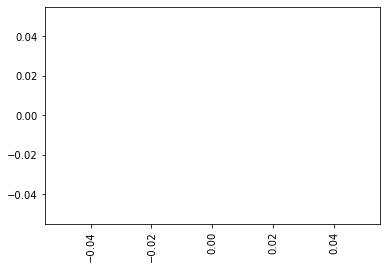

In [78]:
final_table[(~final_table['early_developmental']) & (final_table['private'])].insertion.value_counts().plot(kind='bar').set_title('Germline private TE insertions')

IndexError: index 0 is out of bounds for axis 0 with size 0

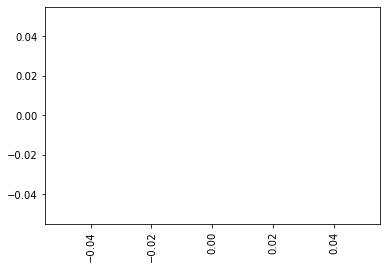

In [79]:
final_table[(final_table['median_coverage'] >=10) & (~final_table['early_developmental']) & (final_table['private'])].insertion.value_counts().plot(kind='bar').set_title('Germline private TE insertions')

In [ ]:
final_table[(~final_table['early_developmental']) & (final_table['private']) & (final_table['insertion'] == 'copia')]

In [80]:
final_table[final_table['median_coverage'] < 10]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,R54_head,R56_head,R58_head,R60_head,R62_head,R64_head,R42A_head,R42B_head,median_coverage,early_developmental
19,0,X,18121886,18121891,rover,+,True,1,{H7_gut_2},"[(3, 7)]",...,2,0,1,2,0,1,0,0,2.0,False
84,0,X,10076846,10076851,rover,+,True,1,{R35_gut_0},"[(2, 3)]",...,5,3,6,9,8,10,1,1,7.0,False
86,0,X,9699886,9699891,rover,+,True,1,{R33_gut_4},"[(14, 11)]",...,1,5,3,13,5,7,4,4,8.0,False
87,0,X,9344347,9344351,rover,+,True,1,{R33_gut_1},"[(7, 6)]",...,1,7,3,13,5,6,4,4,8.0,False
112,0,X,4676540,4676545,rover,+,True,1,{H7_gut_19},"[(5, 10)]",...,2,0,1,5,0,3,0,0,4.0,False
114,0,X,4675507,4675514,rover,+,True,1,{H4_gut_7},"[(13, 19)]",...,5,3,0,21,7,10,4,4,9.0,False
120,0,X,4210325,4210330,rover,+,True,1,{R35_gut_0},"[(5, 5)]",...,12,5,4,21,8,5,4,4,9.0,False
227,0,3R,18393223,18393227,rover,+,True,1,{R27_gut_1},"[(11, 12)]",...,0,2,3,14,4,6,0,0,6.0,False
330,0,3L,22672936,22672940,rover,+,True,1,{R51_gut_1},"[(14, 13)]",...,0,2,0,3,4,3,2,2,3.0,False
382,0,3L,16149033,16149037,copia,+,True,1,{R31_gut_3},"[(5, 17)]",...,6,1,3,3,6,8,1,1,6.0,False


In [81]:
final_table.to_csv(FINAL_TABLE, sep='\t', index=None)

In [82]:
final_table

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,R54_head,R56_head,R58_head,R60_head,R62_head,R64_head,R42A_head,R42B_head,median_coverage,early_developmental
0,0,Y,3631688,3631688,Stalker3,+,True,1,{R30_head_260},"[(10, 2)]",...,70,59,52,45,92,62,59,59,62.0,False
1,0,Y,1445089,1445095,rover,+,True,1,{R43_gut_1},"[(19, 11)]",...,58,40,33,68,38,44,52,52,58.0,False
2,0,X,22848299,22848303,rover,+,True,1,{R39_gut_55},"[(0, 9)]",...,87,69,93,71,88,90,67,67,81.0,False
3,0,X,22835722,22835727,copia,+,True,1,{R57_gut_87},"[(9, 4)]",...,56,42,60,44,49,56,41,41,56.0,False
4,0,X,22598274,22598286,G-element,+,True,1,{R53_gut_39},"[(0, 3)]",...,86,60,89,51,69,77,66,66,69.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,0,2L,1446792,1446799,rover,+,True,1,{H7_gut_13},"[(12, 15)]",...,6,6,5,11,10,4,6,6,8.0,False
742,0,2L,1140710,1140711,rover,+,True,1,{H7_gut_11},"[(5, 10)]",...,10,4,8,9,12,15,7,7,13.0,False
743,0,2L,1053755,1053758,rover,+,True,1,{R33_gut_0},"[(13, 13)]",...,8,3,8,13,11,9,5,5,13.0,False
744,0,2L,482108,482112,rover,+,True,1,{H4_gut_1},"[(28, 10)]",...,24,31,34,22,28,35,32,32,33.0,False
